<a href="https://colab.research.google.com/github/Kovylyaev/Music_MMLS/blob/main/MUSIC_MMLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music MMLS

# Библиотеки

In [100]:
!pip install pydub

%matplotlib inline
import librosa
import librosa.display
import IPython
import IPython.display as ipd
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import shutil
import kagglehub
import os
import torch
from torch import optim
from torch import clamp
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchaudio
from torchaudio.functional import resample
from torchvision.transforms import v2
from torchaudio.transforms import Spectrogram, MelSpectrogram, AmplitudeToDB
import math
from sklearn.model_selection import train_test_split
import random
from time import time
from tqdm import tqdm
from pydub import AudioSegment

# Настройки окружения

In [2]:
!mkdir /content/sample_data/Data
!mkdir /content/sample_data/Data/all_records
!mkdir /content/sample_data/Data/noise
!mkdir /content/states

In [3]:
SEED = 11

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Вспомогательное

## Скачивание

In [4]:
def download_data(dataset_path, out_path, dataset_path_add = None, audio_duration = None):
    path = kagglehub.dataset_download(dataset_path)
    path = shutil.move(path, '/content/sample_data/temp_Data')

    if dataset_path_add is not None:
        path = os.path.join(path, dataset_path_add)

    for folder in os.listdir(path):
        for file_name in os.listdir(path + '/' + folder):
            full_path = os.path.join(path, folder, file_name)

            if audio_duration is not None:
                sound = AudioSegment.from_file(full_path)
                num_segments = math.ceil(len(sound) / (audio_duration * 1000))

                for i in range(num_segments):
                    start_time = i * audio_duration * 1000
                    end_time = min((i + 1) * audio_duration * 1000, len(sound))
                    segment = sound[start_time:end_time]

                    segment.export(f"{out_path}/{file_name}_part_{i+1}.wav", format="wav")
            else:
                shutil.move(full_path, os.path.join(out_path, file_name))


## Визуализация

### WaveForm

In [5]:
def plot_waveform(waveform, sample_rate, suptitle="waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(1, 1, figsize=(10, 2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(suptitle)

### Mel Spectrogram

In [6]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

## Трансформации

In [7]:
def do_db_mel_spec(waveform, sample_rate):
  db_mel = nn.Sequential(
      MelSpectrogram(sample_rate, n_fft=2000, win_length=2000),
      AmplitudeToDB()
  )

  return db_mel(waveform)

## Разное

In [8]:
def listdir_fullpath(dir):
    return [os.path.join(dir, file) for file in os.listdir(dir)]

In [9]:
def pad(arr, max_len, val):
  arr = torch.squeeze(arr)
  if arr.shape[0] >= max_len:
    return arr[:max_len]

  padding = torch.tensor([val] * (max_len - len(arr)))

  arr = torch.cat((arr, padding), 0)
  return torch.unsqueeze(arr, 0)

# Данные

## Скачивание данных

In [10]:
download_data(dataset_path="andradaolteanu/gtzan-dataset-music-genre-classification", out_path='/content/sample_data/Data/all_records', dataset_path_add='Data/genres_original')
download_data(dataset_path="mlneo07/random-noise-audio", out_path='/content/sample_data/Data/noise', audio_duration=30)

100%|██████████| 1.21G/1.21G [00:21<00:00, 61.6MB/s]

Extracting files...


100%|██████████| 6.53G/6.53G [01:35<00:00, 73.1MB/s]

Extracting files...


## Посмотреть данные

### Загрузка

In [38]:
sample_rate = 32000
size = sample_rate * 30


audio_file = '/content/debug_clean/blues.00002.wav'#'/content/sample_data/Data/all_records/blues.00000.wav'
audio, sample_rate_a = torchaudio.load(audio_file, normalize=True)

noise_file = '/content/debug_noise/brown_noise_48000_0.wav_part_1.wav'#'/content/sample_data/Data/noise/brown_noise_32000_0.wav_part_1.wav'
noise, sample_rate_n = torchaudio.load(noise_file, normalize=True)

sample_rate = 32000
audio = resample(audio, orig_freq=sample_rate_a, new_freq=sample_rate)
noise = resample(noise, orig_freq=sample_rate_n, new_freq=sample_rate)

audio = pad(audio, size, 0)
noise = pad(noise, size, 0)
print(f"Sequence lenght - {size}")

audio_with_noise = clamp(audio + noise, min=-1, max=1)

Sequence lenght - 960000


### Визуализация

In [39]:
plot_waveform(audio, sample_rate, suptitle='Clean audio')

plot_waveform(noise, sample_rate, suptitle='Noise')

plot_waveform(audio_with_noise, sample_rate, suptitle='Audio + noise')

ValueError: not enough values to unpack (expected 2, got 1)

### Послушать

In [40]:
# Clean audio
ipd.Audio(audio, rate=sample_rate)

In [41]:
# Noise
ipd.Audio(noise, rate=sample_rate)

In [42]:
# Audio + noise
ipd.Audio(audio_with_noise, rate=sample_rate)

### Мел-спектрограммы

In [43]:
clean_db_mel_spec = do_db_mel_spec(audio, sample_rate)

noise_db_mel_spec = do_db_mel_spec(noise, sample_rate)

with_noise_db_mel_spec = do_db_mel_spec(audio_with_noise, sample_rate)
with_noise_db_mel_spec.shape

torch.Size([128, 961])

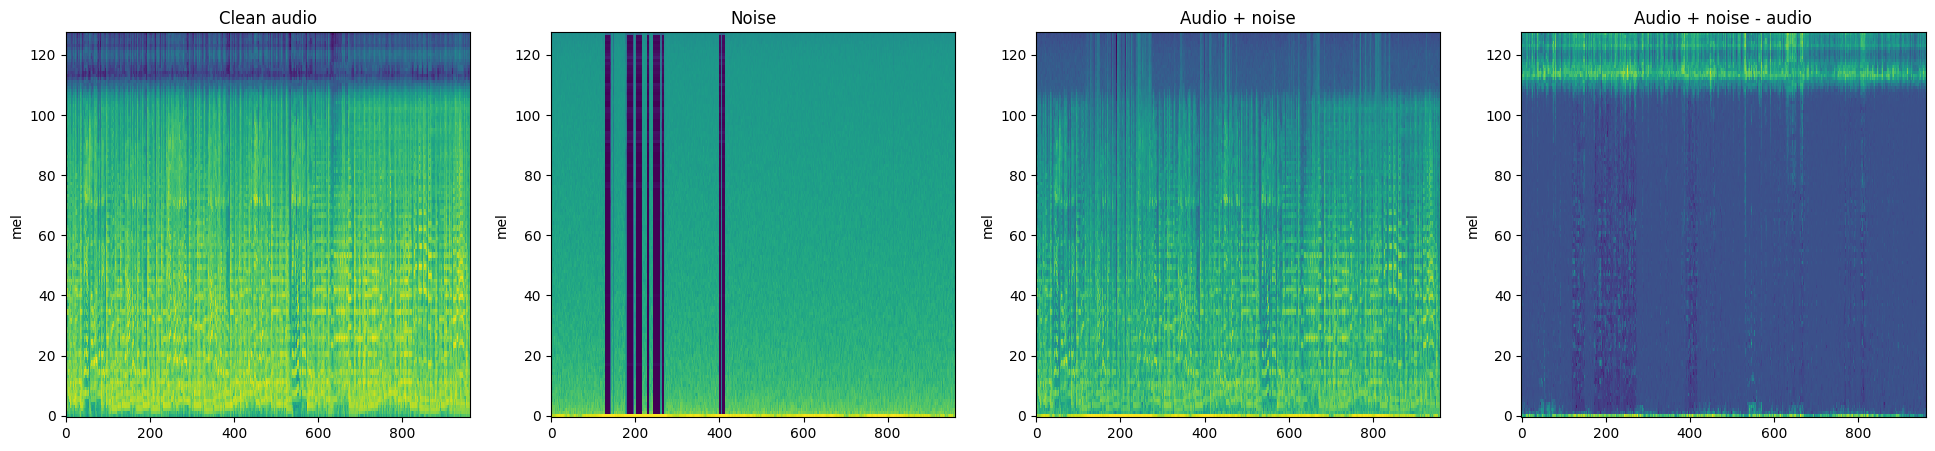

In [44]:
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

plot_spectrogram(clean_db_mel_spec.squeeze(), title='Clean audio', ylabel="mel", ax=axs[0])

plot_spectrogram(noise_db_mel_spec.squeeze(), title='Noise', ylabel="mel", ax=axs[1])

plot_spectrogram(with_noise_db_mel_spec.squeeze(), title='Audio + noise', ylabel="mel", ax=axs[2])

plot_spectrogram((with_noise_db_mel_spec - clean_db_mel_spec).squeeze(), title='Audio + noise - audio',  ylabel="mel", ax=axs[3])


# Ауги

In [231]:
def transform(pic):
  pic = (pic - pic.min()) / (pic.max() - pic.min())

  trans = v2.Compose([
      v2.Normalize(mean=[0.5], std=[0.225])
  ])

  return trans(pic)

transform(torch.unsqueeze(clean_db_mel_spec, dim=0))

tensor([[[ 1.0303,  0.7037,  0.5430,  ...,  1.1291,  1.1103,  1.3905],
         [ 1.0187,  0.8187,  0.7554,  ...,  1.4338,  1.3212,  1.4479],
         [ 1.2732,  1.3537,  1.3847,  ...,  1.4214,  1.2339,  1.4004],
         ...,
         [-0.3870, -0.8987, -0.9906,  ..., -0.8722, -1.1116, -0.1256],
         [-0.3849, -1.2059, -1.0968,  ..., -1.0139, -1.1149, -0.1251],
         [-0.3741, -1.3335, -1.2465,  ..., -1.1199, -1.1816, -0.1285]]])

# Датасет

In [232]:
class Music_Dataset(torch.utils.data.Dataset):
    def __init__(self, clean_files: str, noise_files: str):
        """Initializes Dataset with passed files.
        Args:
            clean_files: path to files of clean music,
            noise_files: path to files of noise.
        """
        self.clean_music = list(clean_files)
        self.clean_num = len(self.clean_music)

        self.noise = list(noise_files)
        self.noise_num = len(self.noise)


    def __getitem__(self, idx: int):
        """Returns the object by given index.
        Args:
            idx - index of the record.
        Returns:
            record with noise and clean one.
        """

        clean_ind = idx // self.noise_num
        clean_record, sample_rate_clean = torchaudio.load(self.clean_music[clean_ind], normalize=True)

        noise_ind = idx % self.noise_num
        noise_record, sample_rate_noise = torchaudio.load(self.noise[noise_ind], normalize=True)

        clean_record = resample(clean_record, orig_freq=sample_rate_clean, new_freq=sample_rate)
        noise_record = resample(noise_record, orig_freq=sample_rate_noise, new_freq=sample_rate)

        clean_record = pad(clean_record, size, 0)
        noise_record = pad(noise_record, size, 0)

        record_with_noise = clamp(clean_record + noise_record, min=-1, max=1)


        db_melspec_with_noise = do_db_mel_spec(record_with_noise, sample_rate)
        db_melspec_clean = do_db_mel_spec(clean_record, sample_rate)

        with_noise = transform(torch.unsqueeze(db_melspec_with_noise, dim=0))
        clean = transform(torch.unsqueeze(db_melspec_clean, dim=0))

        return with_noise, clean


    def __len__(self):
        """Returns num of different combinations of clean_rec + noise, containing in dataset."""

        return self.clean_num * self.noise_num

# Модель

In [233]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)



class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)



class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [234]:
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.n_channels = n_channels

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32))
        self.down2 = (Down(32, 64))
        self.down3 = (Down(64, 128))
        self.down4 = (Down(128, 256))  #1024
        self.up1 = (Up(256, 128))
        self.up2 = (Up(128, 64))
        self.up3 = (Up(64, 32))
        self.up4 = (Up(32, 16))
        self.outc = nn.Conv2d(16, n_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        pred = self.outc(x)
        return pred

# Метрики

In [235]:
def calc_(true_spec, pred_spec):
  return 42

# Функции обучения

## Train

In [236]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for specs_noisy, specs_clean in tqdm(loader, desc='Train'):

        specs_noisy = specs_noisy.to(device)
        specs_clean = specs_clean.to(device)

        optimizer.zero_grad()

        predicted_clean = model(specs_noisy)


        loss = criterion(predicted_clean, specs_clean)
        acc = calc_(specs_clean, predicted_clean)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc


    return epoch_loss / len(loader), epoch_acc / len(loader)

## Валидация

In [237]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for specs_noisy, specs_clean in tqdm(loader, desc='Val'):

            specs_noisy = specs_noisy.to(device)
            specs_clean = specs_clean.to(device)


            predicted_clean = model(specs_noisy)


            loss = criterion(predicted_clean, specs_clean)
            acc = calc_(specs_clean, predicted_clean)

            epoch_loss += loss.item()
            epoch_acc += acc

    return epoch_loss / len(loader), epoch_acc / len(loader)

## Время

In [238]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Настройки обучения

## Параметры обучения

In [255]:
batch_size = 16
val_size = 0.5


model = UNet(n_channels=1)
model.load_state_dict(torch.load('/content/states/best_model.pt'))
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer.load_state_dict(torch.load('/content/states/best_optimizer.pt'))
criterion = nn.MSELoss()

N_EPOCHS = 50

## Загрузчики данных

In [252]:
# clean_dir = '/content/sample_data/Data/all_records/'
# noise_dir = '/content/sample_data/Data/noise/'

clean_dir = '/content/debug_clean/'
noise_dir = '/content/debug_noise/'

clean_files = listdir_fullpath(clean_dir)
noise_files = listdir_fullpath(noise_dir)

train_clean_files, test_clean_files = train_test_split(clean_files, test_size=val_size, random_state=42)
train_noise_files, test_noise_files = train_test_split(noise_files, test_size=val_size, random_state=42)

train_dataset = Music_Dataset(
    clean_files=train_clean_files,
    noise_files=train_noise_files,
)
test_dataset = Music_Dataset(
    clean_files=test_clean_files,
    noise_files=test_noise_files,
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0
)

In [253]:
train_clean_files, train_noise_files

(['/content/debug_clean/blues.00002.wav'],
 ['/content/debug_noise/brown_noise_48000_0.wav_part_1.wav'])

# Обучение

Epoch: 100 | Epoch Time: 0m 0s
	Train Loss: 0.008 | Train Acc: 4200.00%

	 Val Loss: 0.111 |  Val Acc: 4200.00%



Text(0.5, 1.0, 'Vall Loss')

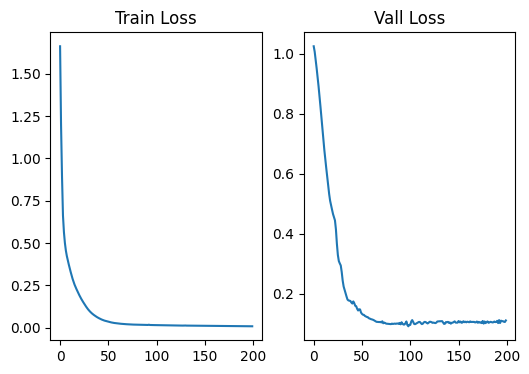

In [256]:
from IPython.display import clear_output
best_val_loss = float("inf")
train_loss = float("inf")

# train_losses = []
# val_losses = []

for epoch in range(100):

    start_time = time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, test_loader, criterion)
    end_time = time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/content/states/best_model.pt")
        torch.save(optimizer.state_dict(), "/content/states/best_optimizer.pt")
    torch.save(model.state_dict(), "/content/states/last_model.pt")
    torch.save(optimizer.state_dict(), "/content/states/last_optimizer.pt")


    clear_output()
    print(f"Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%\n")
    print(f"\t Val Loss: {val_loss:.3f} |  Val Acc: {val_acc * 100:.2f}%\n")


    train_losses.append(train_loss)
    val_losses.append(val_loss)

fig, ax = plt.subplots(1,2, figsize=(6,4))
ax[0].plot(train_losses)
ax[0].set_title('Train Loss')
ax[1].plot(val_losses)
ax[1].set_title('Vall Loss')


In [243]:
model(torch.unsqueeze(torch.unsqueeze(with_noise_db_mel_spec, dim=0), dim=0).to(device))

tensor([[[[  7.3062,  11.8334,  13.7172,  ...,  14.2501,  12.0766,   6.4734],
          [ 14.2289,  22.3241,  24.9649,  ...,  27.5356,  22.9408,  11.8175],
          [ 17.0755,  26.0626,  30.0744,  ...,  31.0091,  26.0316,  13.5455],
          ...,
          [ -6.0169, -11.3416, -15.8410,  ..., -18.4203, -15.1187,  -8.9435],
          [ -6.1816, -11.5061, -16.1735,  ..., -18.2564, -14.7639,  -8.6630],
          [ -4.6061,  -8.2856, -11.7965,  ..., -13.2071, -10.5014,  -6.1112]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

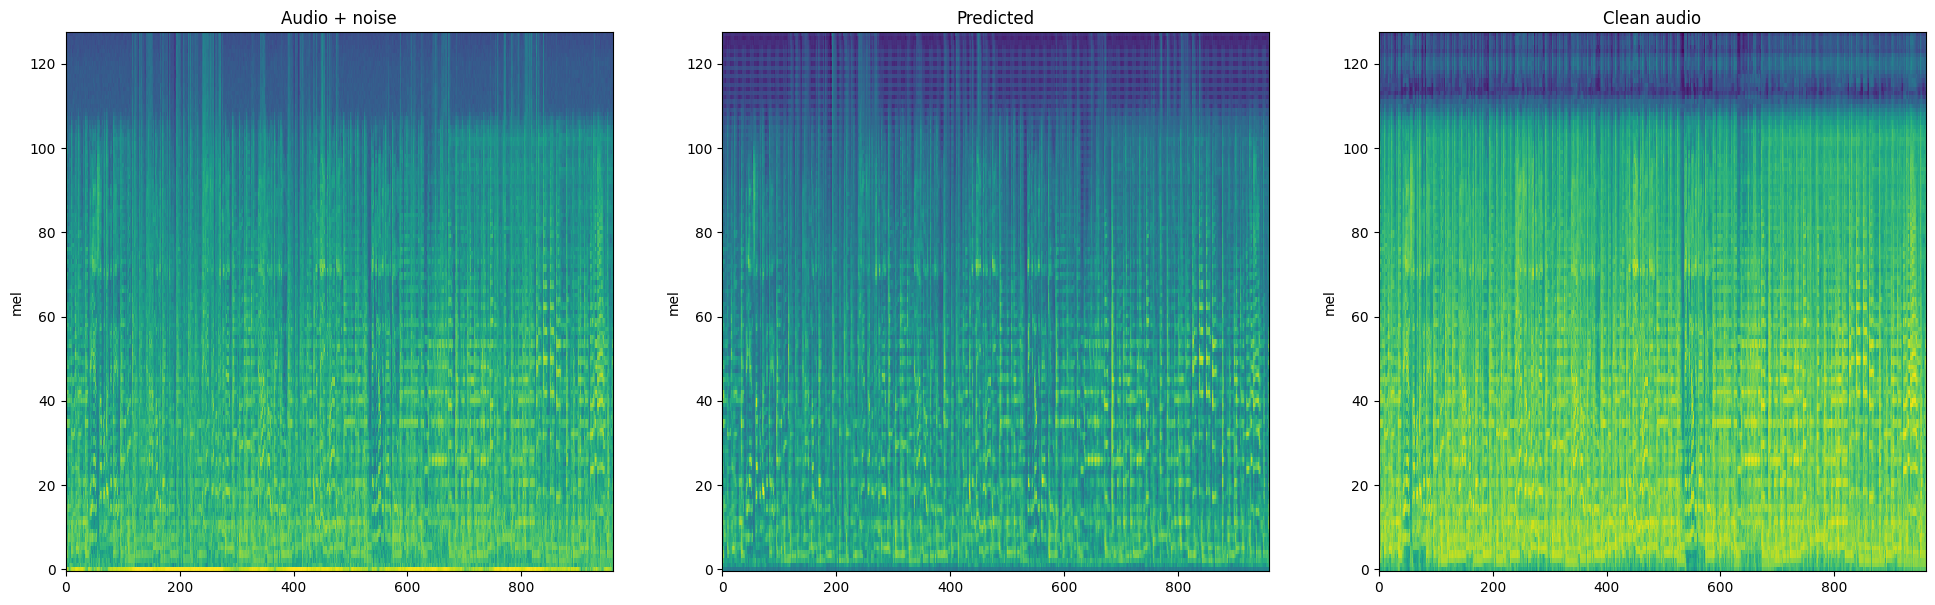

In [248]:
predicted_db_mel_spec = model(torch.unsqueeze(torch.unsqueeze(with_noise_db_mel_spec, dim=0), dim=0).to(device))


fig, axs = plt.subplots(1, 3, figsize=(24, 7))

plot_spectrogram(with_noise_db_mel_spec.squeeze(), title='Audio + noise', ylabel="mel", ax=axs[0])

plot_spectrogram(predicted_db_mel_spec.to('cpu').detach().numpy().squeeze(), title='Predicted', ylabel="mel", ax=axs[1])

plot_spectrogram(clean_db_mel_spec.squeeze(), title='Clean audio', ylabel="mel", ax=axs[2])